## Лабораторная работ 2: Знакомство с архитектурой YOLO для детекции объектов

В рамках данной лабораторной работы будет использоваться реализация YOLOv8 с открытым исходным кодом для обучения и запуска данной модели.

Перед началом работы стоит убедится, что установлена среда выполнения с использованием GPU. Изменить среду выполнения можно в настройке ресурсов Colab.

Для начала работы необходимо уставновить библиотеку с моделью в текущее окружение, выполнив ячейку ниже:

In [1]:
#!pip install ultralytics

Ознакомиться с документацией данной библиотеки можно по [следющуей ссылке](https://docs.ultralytics.com/).

Далее предлагается ознакомиться с функционалом для работы с библиотекой ultralytics для Python.

In [2]:
# Сначала следует загрузить тестовое изображение
!curl https://hyperbicycles.com/cdn/shop/files/hyper-collection-e-bikes-29in-mid-drive-mtb_5dfcef23-4a4c-46a8-81c2-16dca199774a_1800x.jpg?v=1657670368 -o test.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  441k  100  441k    0     0  1025k      0 --:--:-- --:--:-- --:--:-- 1028k


In [3]:
# Запуск модели самой быстрой YOLOv8-Nano (содержит наименьшее количество параметров)
!yolo predict model=yolov8n.pt source='test.jpg'


Ultralytics YOLOv8.0.200  Python-3.9.7 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 with Max-Q Design, 8192MiB)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs

image 1/1 C:\Users\gribo\Desktop\Android\Lab2\test.jpg: 416x640 1 person, 1 bicycle, 56.8ms
Speed: 2.0ms preprocess, 56.8ms inference, 5.0ms postprocess per image at shape (1, 3, 416, 640)
Results saved to runs\detect\predict8
 Learn more at https://docs.ultralytics.com/modes/predict


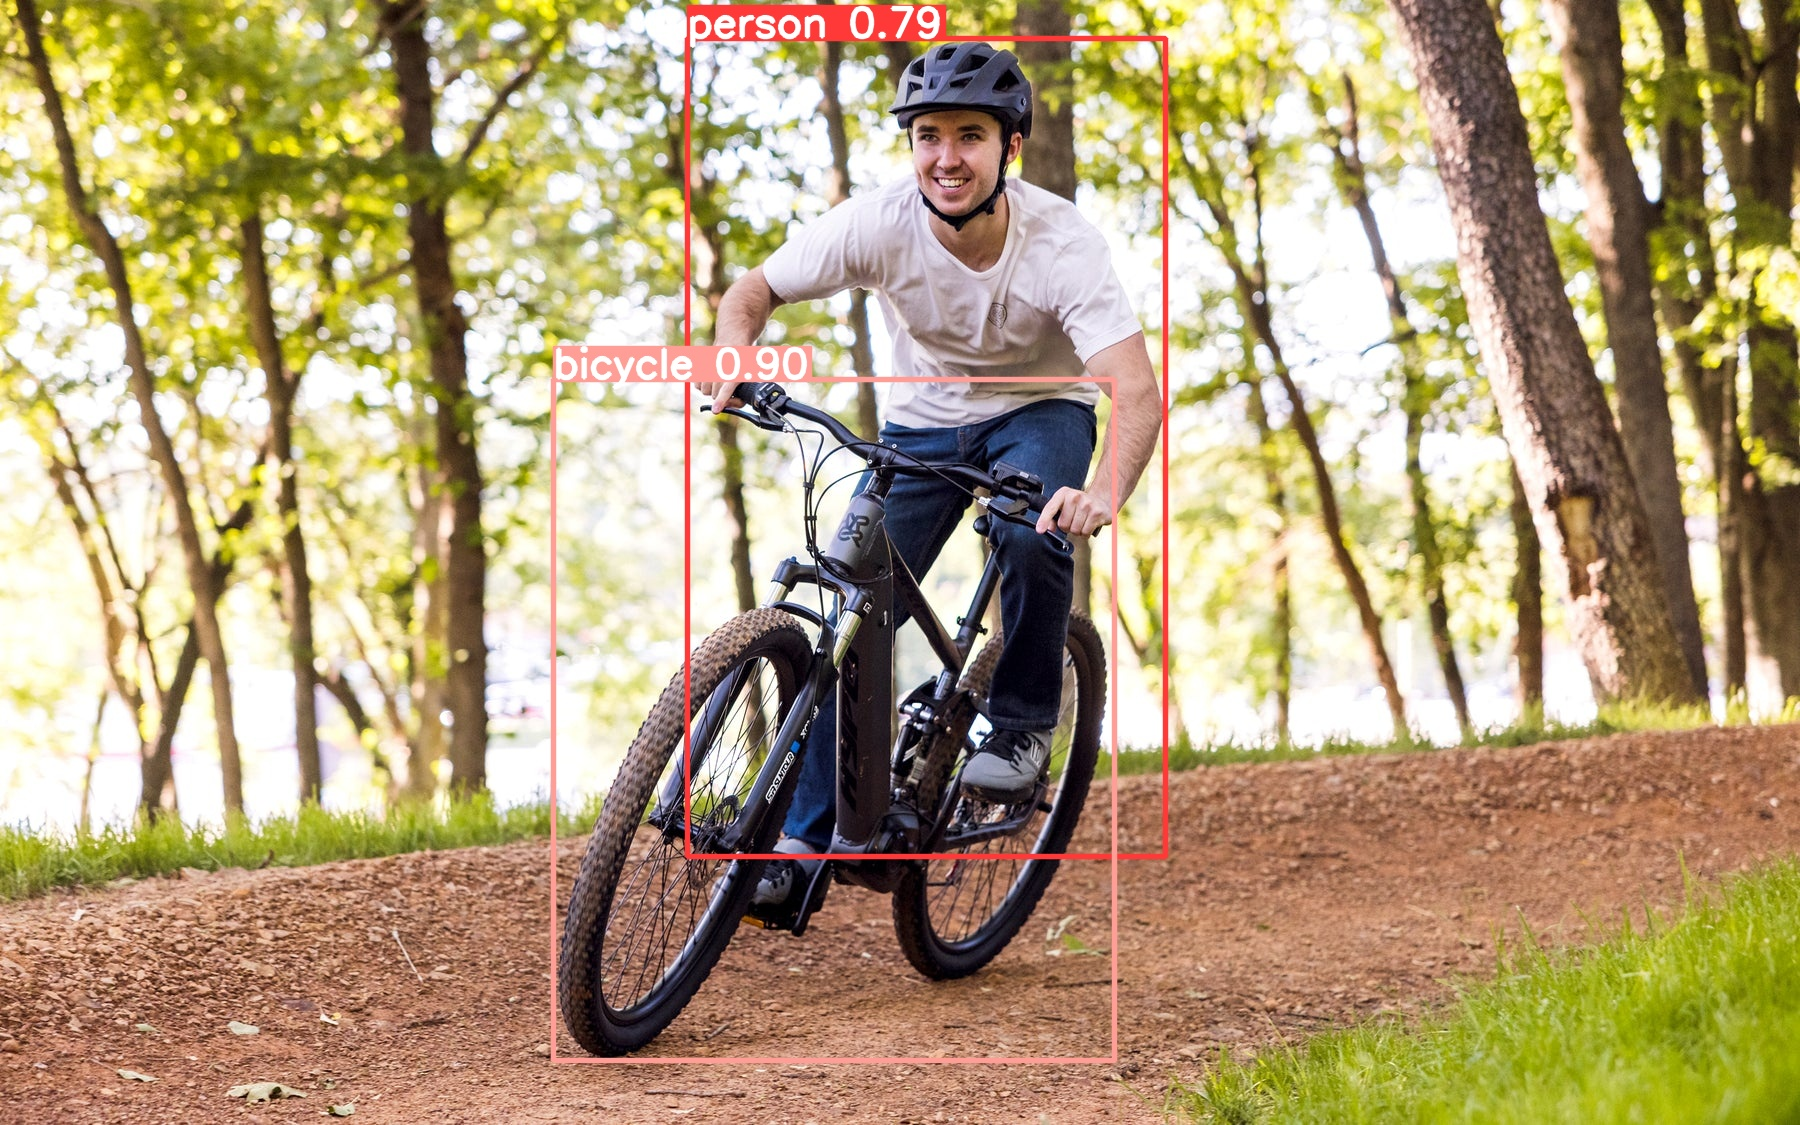

In [4]:
# Визуализация результата работы модели
# Импортируем функцию для отрисовки изображения напрямую в браузерной среде выполнения
from IPython.display import Image

Image(filename='runs/detect/predict/test.jpg', width=1000)

Выше были представлены консольные команды для запуска модели YOLO, но также данной библиотекой можно пользовать при реализации Python скриптоп, пример кода приведён в ячейках ниже.

In [5]:
from ultralytics import YOLO
#from google.colab.patches import cv2_imshow
import cv2

model = YOLO('yolov8n.pt')
results = model(['test.jpg'])
result = results[0].cpu()

detection_visualization = result.plot()
detection_visualization = cv2.resize(detection_visualization, None, fx=1/2, fy=1/2)

#cv2_imshow(detection_visualization)
cv2.namedWindow('custom window', cv2.WINDOW_KEEPRATIO)
cv2.imshow('custom window', detection_visualization)
cv2.resizeWindow('custom window', 800, 600)

cv2.waitKey(0)
cv2.destroyAllWindows()


0: 416x640 1 person, 1 bicycle, 57.8ms
Speed: 3.0ms preprocess, 57.8ms inference, 5.0ms postprocess per image at shape (1, 3, 416, 640)


In [6]:
# Также возможно отрисовать детекции на кадре с помощью библиотеки OpenCV
import numpy as np

boxes = result.boxes.data[:, :4].numpy().astype(np.int32)    # Координаты прямоугольника вокруг найденного объекта
probs = result.boxes.conf.numpy()                            # Уверенность сети в данной детекции
cls = result.boxes.cls.numpy().astype(np.int32)              # Индексы имён классов
names = [result.names[c_idx] for c_idx in cls]               # Конвертация индексов в название классов

image = cv2.imread('test.jpg', cv2.IMREAD_COLOR)  # Открытие цветного изображения (примечание: открывается в BGR)

detection_visualization = image.copy()

text_font = cv2.FONT_HERSHEY_DUPLEX
text_scale = 2.0
colors = [(50, 20, 200), (200, 20, 100)]
text_thickness = 5

for detecion_id in range(len(boxes)):
  target_object_name = names[detecion_id]
  target_object_box = boxes[detecion_id]  # XYXY format
  target_object_prob = float(probs[detecion_id])

  print('Box: {}, name: {}, confidence: {:.2f}'.format(target_object_box, target_object_name, target_object_prob))

  detection_visualization = cv2.rectangle(
      detection_visualization,
      tuple(target_object_box[:2]),
      tuple(target_object_box[2:]),
      colors[detecion_id % len(colors)],
      5
  )


for detecion_id in range(len(boxes)):
  target_object_name = names[detecion_id]
  target_object_box = boxes[detecion_id]
  target_object_prob = float(probs[detecion_id])

  input_text = '{} {:.2f}'.format(target_object_name, target_object_prob)

  (text_width, text_height), baseline = cv2.getTextSize(input_text, text_font, text_scale, text_thickness)

  detection_visualization = cv2.putText(
    detection_visualization,
    input_text,
    (target_object_box[0] + 10, target_object_box[1] + text_height + baseline),
    text_font,
    text_scale,
    colors[detecion_id % len(colors)],
    text_thickness
  )


detection_visualization = cv2.resize(detection_visualization, None, fx=1/2, fy=1/2)

#cv2_imshow(detection_visualization)
cv2.namedWindow('custom window', cv2.WINDOW_KEEPRATIO)
cv2.imshow('custom window', detection_visualization)
cv2.resizeWindow('custom window', 800, 600)

cv2.waitKey(0)
cv2.destroyAllWindows()

Box: [ 553  379 1114 1060], name: bicycle, confidence: 0.90
Box: [ 687   38 1165  856], name: person, confidence: 0.79


## Экспорт модели
Библиотека позволяет экспортировать модель YOLOv8 для использования на различных платфомах. Например формат ONNX хорошо оптимизирован для запуска сверточных нейронных сетей на процессорах с архитектурой x86, формат CoreML необзодим для запуска моделей на устройствах от компании Apple, формат модели фреймворка TensorFlow-Lite эффективно запускат модели на устройствах под операционной системой Android.
Ниже в ячейке представлены примеры экспорта модели в различные форматы через средсва Python.

In [7]:
# Для x86
save_path = model.export(format="onnx")
!echo "ONNX SAVE PATH: $save_path"; ls -lah $save_path

# # Для iOS
# save_path = model.export(format="coreml")
# !echo "CoreML SAVE PATH: $save_path"; ls -lah $save_path

# # Для Android
# save_path = model.export(format="tflite")
# !echo "TF-Lite SAVE PATH: $save_path"; ls -lah $save_path

Ultralytics YOLOv8.0.200  Python-3.9.7 torch-2.0.1+cu117 CPU (Intel Core(TM) i7-9750H 2.60GHz)

PyTorch: starting from 'yolov8n.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (6.2 MB)

ONNX: starting export with onnx 1.14.1 opset 17...
ONNX: export success  0.8s, saved as 'yolov8n.onnx' (12.2 MB)

Export complete (2.6s)
Results saved to C:\Users\gribo\Desktop\Android\Lab2
Predict:         yolo predict task=detect model=yolov8n.onnx imgsz=640  
Validate:        yolo val task=detect model=yolov8n.onnx imgsz=640 data=coco.yaml  
Visualize:       https://netron.app


============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

"ONNX SAVE PATH: yolov8n.onnx"; ls -lah yolov8n.onnx


#### Также библиотека предоставляет консольный функционал для экспорта моделей, пример запуска написан в ячейке ниже:

In [8]:
!yolo export model=yolov8n.pt format=onnx simplify half

============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============

Ultralytics YOLOv8.0.200  Python-3.9.7 torch-2.0.1+cu117 CPU (Intel Core(TM) i7-9750H 2.60GHz)
WARNING  half=True only compatible with GPU export, i.e. use device=0
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs

PyTorch: starting from 'yolov8n.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (6.2 MB)

ONNX: starting export with onnx 1.14.1 opset 17...
ONNX: simplifying with onnxsim 0.4.35...
ONNX: export success  1.2s, saved as 'yolov8n.onnx' (12.2 MB)

Export complete (3.3s)
Results saved to C:\Users\gribo\Desktop\Android\Lab2
Predict:         yolo predict task=detect model=yolov8n.onnx imgsz=640  
Validate:        yolo val task=detect model=yolov8n.onnx imgsz=640 data=coco.yaml  
Visualize:       https://netron.app
 Learn more at https://docs.ultralytics.com/modes/export



verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



## Задание 1
Теперь попробуйте вернуться к исполняемой ячейке, где происходит скачивание изображения. Найдите в интернете любое изображение с объектами (люди, машины, элементы декора) и замените URL из ячейки на ссылку на выше изображание и произведите шаги с запуском модели и визуализции снова, с вашим изображанием. Также необходимо поменять имя изображения, например на `test2.jpg`.

In [9]:
!curl https://avatars.dzeninfra.ru/get-zen_doc/10093652/pub_64b62c13cd6be910990486f9_64b62e59f29af47bcd44a2fd/scale_2400 -o test2.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 68686  100 68686    0     0   312k      0 --:--:-- --:--:-- --:--:--  313k


In [10]:
!yolo predict model=yolov8n.pt source='test2.jpg'

Ultralytics YOLOv8.0.200  Python-3.9.7 torch-2.0.1+cu117 CPU (Intel Core(TM) i7-9750H 2.60GHz)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs

image 1/1 C:\Users\gribo\Desktop\Android\Lab2\test2.jpg: 640x640 1 cup, 2 chairs, 2 couchs, 3 potted plants, 120.7ms
Speed: 3.0ms preprocess, 120.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict9
 Learn more at https://docs.ultralytics.com/modes/predict


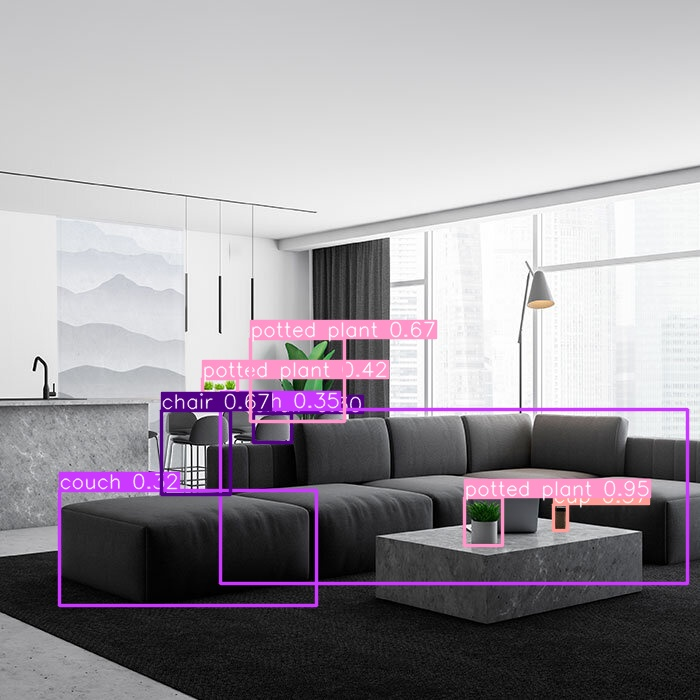

In [11]:
# Визуализация результата работы модели

Image(filename='runs/detect/predict3/test2.jpg', width=1000)

In [12]:
# Детекции на кадре с помощью библиотеки OpenCV

model = YOLO('yolov8n.pt')
results = model(['test2.jpg'])
result = results[0].cpu()

detection_visualization = result.plot()
detection_visualization = cv2.resize(detection_visualization, None, fx=1/2, fy=1/2)


boxes = result.boxes.data[:, :4].numpy().astype(np.int32)    # Координаты прямоугольника вокруг найденного объекта
probs = result.boxes.conf.numpy()                            # Уверенность сети в данной детекции
cls = result.boxes.cls.numpy().astype(np.int32)              # Индексы имён классов
names = [result.names[c_idx] for c_idx in cls]               # Конвертация индексов в название классов

image = cv2.imread('test2.jpg', cv2.IMREAD_COLOR)  # Открытие цветного изображения (примечание: открывается в BGR)

detection_visualization = image.copy()

text_font = cv2.FONT_HERSHEY_DUPLEX
text_scale = 1.0
colors = [(50, 20, 200), (200, 20, 100)]
text_thickness = 1

for detecion_id in range(len(boxes)):
  target_object_name = names[detecion_id]
  target_object_box = boxes[detecion_id]  # XYXY format
  target_object_prob = float(probs[detecion_id])

  print('Box: {}, name: {}, confidence: {:.2f}'.format(target_object_box, target_object_name, target_object_prob))

  detection_visualization = cv2.rectangle(
      detection_visualization,
      tuple(target_object_box[:2]),
      tuple(target_object_box[2:]),
      colors[detecion_id % len(colors)],
      1
  )


for detecion_id in range(len(boxes)):
  target_object_name = names[detecion_id]
  target_object_box = boxes[detecion_id]
  target_object_prob = float(probs[detecion_id])

  input_text = '{} {:.2f}'.format(target_object_name, target_object_prob)

  (text_width, text_height), baseline = cv2.getTextSize(input_text, text_font, text_scale, text_thickness)

  detection_visualization = cv2.putText(
    detection_visualization,
    input_text,
    (target_object_box[0] + 10, target_object_box[1] + text_height + baseline),
    text_font,
    text_scale,
    colors[detecion_id % len(colors)],
    text_thickness
  )


detection_visualization = cv2.resize(detection_visualization, None, fx=1/2, fy=1/2)

#cv2_imshow(detection_visualization)
cv2.namedWindow('custom window', cv2.WINDOW_KEEPRATIO)
cv2.imshow('custom window', detection_visualization)
cv2.resizeWindow('custom window', 700, 700)

cv2.waitKey(0)
cv2.destroyAllWindows()


0: 640x640 1 cup, 2 chairs, 2 couchs, 3 potted plants, 38.9ms
Speed: 6.0ms preprocess, 38.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Box: [464 497 502 545], name: potted plant, confidence: 0.95
Box: [250 338 344 421], name: potted plant, confidence: 0.67
Box: [161 410 230 494], name: chair, confidence: 0.67
Box: [553 504 567 530], name: cup, confidence: 0.57
Box: [202 378 237 400], name: potted plant, confidence: 0.42
Box: [220 409 687 583], name: couch, confidence: 0.35
Box: [ 59 490 316 605], name: couch, confidence: 0.32
Box: [253 413 291 442], name: chair, confidence: 0.30


Теперь попробуйте скачать видео файл и запустить на нём модель. Для этого запустите ячейки ниже:

In [13]:
#!pip install pytube

In [14]:
from pytube import YouTube
YouTube("https://www.youtube.com/watch?v=fLeJJPxua3E").streams.filter(progressive=True, file_extension='mp4').first().download('test_video')

'C:\\Users\\gribo\\Desktop\\Android\\Lab2\\test_video\\Best Short Motivational Speech Video - 24 HOURS - 1-Minute Motivation 2.mp4'

In [15]:
#!yolo predict model=yolov8n.pt source='test_video/*'

Если видео не открывается, то скачайте файл из директории `runs/detect/predict3` и воспроизведите его локально на машине

In [16]:
# %%HTML
# <video width="1280" height="720" controls>
#   <source src="runs/detect/predict3/Best Short Motivational Speech Video - 24 HOURS - 1-Minute Motivation 2.avi" type="video/avi">
# </video>

## Обучение собственной модели

Для обучения модели можно взять любой набора данных с сайта [Roboflow](https://universe.roboflow.com/).
Для примера возьмём набор данных детекции людей с [респираторными масками](https://universe.roboflow.com/joseph-nelson/mask-wearing/dataset/19#), чтобы его скачать, выполните код в ячейке ниже:

In [17]:
#!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="Hrz3pdBkU0UwCowauRnm")
project = rf.workspace("joseph-nelson").project("mask-wearing")
dataset = project.version(19).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.134 is required but found version=8.0.200, to fix: `pip install ultralytics==8.0.134`



Extracting Dataset Version Zip to Mask-Wearing-19 in yolov8:: 100%|██████████████| 3880/3880 [00:01<00:00, 1994.28it/s]


Для оубчения моделей из библиотеки ultralytics сначала необходимо подготовить конфигурационный файл, если набор данных скачан из Roboflow, он сгенерирован автоматически и пригалается к набору данных.

In [18]:
!cat Mask-Wearing-19/data.yaml

"cat" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


Для корректного запуска обучения необходимо поправить пути до директорий с изображениями, так как скрипт обучения YOLO будет искать полные пути до директорий с изображениями и разметкой.

In [32]:
import pathlib
import yaml
import os

def delete_first_folder(p: str) -> str:
  return str(pathlib.Path(*pathlib.Path(p).parts[1:]))

def add_root_path(p: str) -> str:
  #return '/content/' + p
    return os.path.join(os.getcwd(), p)

with open('Mask-Wearing-19/data.yaml', 'r') as f:
  data = yaml.safe_load(f)

data['train'] = add_root_path(data['train'])
data['val'] = add_root_path(data['val'])
data['test'] = add_root_path('Mask-Wearing-19/' + delete_first_folder(data['test']))

with open('Mask-Wearing-19/fixed_data.yaml', 'w') as f:
  yaml.safe_dump(data, f)

data

{'names': ['mask', 'no-mask'],
 'nc': 2,
 'roboflow': {'license': 'Public Domain',
  'project': 'mask-wearing',
  'url': 'https://universe.roboflow.com/joseph-nelson/mask-wearing/dataset/19',
  'version': 19,
  'workspace': 'joseph-nelson'},
 'test': 'C:\\Users\\gribo\\Desktop\\Android\\Lab2\\Mask-Wearing-19/test\\images',
 'train': 'C:\\Users\\gribo\\Desktop\\Android\\Lab2\\Mask-Wearing-19/train/images',
 'val': 'C:\\Users\\gribo\\Desktop\\Android\\Lab2\\Mask-Wearing-19/valid/images'}

Теперь можно запустить обучение YOLOv8, для обучение берётся самая легковесная архитектура YOLOv8-Nano.

In [33]:
# Обучение модели Nano на 10 эпохах с размером входного изображения 480 пикселей
# обучение ~2 часа
###!yolo detect train model=yolov8n.pt data="Mask-Wearing-19/fixed_data.yaml" epochs=10 imgsz=480

Ultralytics YOLOv8.0.200  Python-3.9.7 torch-2.0.1+cu117 CPU (Intel Core(TM) i7-9750H 2.60GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=Mask-Wearing-19/fixed_data.yaml, epochs=10, patience=50, batch=16, imgsz=480, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, kera

## Задание 2

1.   Запустите полученную модель на изображениях из интернета и отрисуйте результат детекции (смотрите ячейки выше).
2.   Экспортируйте модель в формат ONNX (смотрите ячейки выше)

Примечание: для выполнения данных заданий создавайте ячейки ниже текущей

In [34]:
!curl https://s0.rbk.ru/v6_top_pics/media/img/8/19/756083731751198.jpg -o test3.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  763k  100  763k    0     0  1330k      0 --:--:-- --:--:-- --:--:-- 1332k


In [43]:
from ultralytics import YOLO
#import cv2_imshow
import cv2

model = YOLO('runs/detect/train5/weights/best.pt')
results = model(['test3.jpg'])
result = results[0].cpu()

detection_visualization = result.plot()
detection_visualization = cv2.resize(detection_visualization, None, fx=1/2, fy=1/2)

cv2.namedWindow('custom window', cv2.WINDOW_KEEPRATIO)
cv2.imshow('custom window', detection_visualization)
cv2.resizeWindow('custom window', 800, 600)
cv2.imwrite('masks.jpg', detection_visualization)

cv2.waitKey(0)
cv2.destroyAllWindows()


0: 320x480 14 masks, 3 no-masks, 37.5ms
Speed: 2.0ms preprocess, 37.5ms inference, 3.0ms postprocess per image at shape (1, 3, 320, 480)


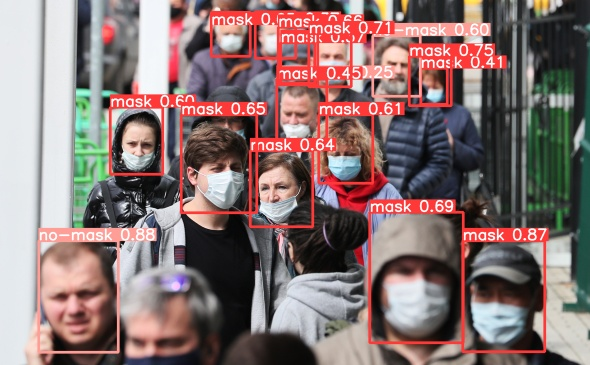

In [45]:
Image(filename='masks.jpg', width=1000)

In [46]:
save_path = model.export(format="onnx")
!echo "ONNX SAVE PATH: $save_path"; ls -lah $save_path

Ultralytics YOLOv8.0.200  Python-3.9.7 torch-2.0.1+cu117 CPU (Intel Core(TM) i7-9750H 2.60GHz)

PyTorch: starting from 'runs\detect\train5\weights\best.pt' with input shape (1, 3, 480, 480) BCHW and output shape(s) (1, 6, 4725) (5.9 MB)

ONNX: starting export with onnx 1.14.1 opset 17...
ONNX: export success  0.8s, saved as 'runs\detect\train5\weights\best.onnx' (11.6 MB)

Export complete (2.5s)
Results saved to C:\Users\gribo\Desktop\Android\Lab2\runs\detect\train5\weights
Predict:         yolo predict task=detect model=runs\detect\train5\weights\best.onnx imgsz=480  
Validate:        yolo val task=detect model=runs\detect\train5\weights\best.onnx imgsz=480 data=Mask-Wearing-19/fixed_data.yaml  
Visualize:       https://netron.app


============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

"ONNX SAVE PATH: runs\detect\train5\weights\best.onnx"; ls -lah runs\detect\train5\weights\best.onnx


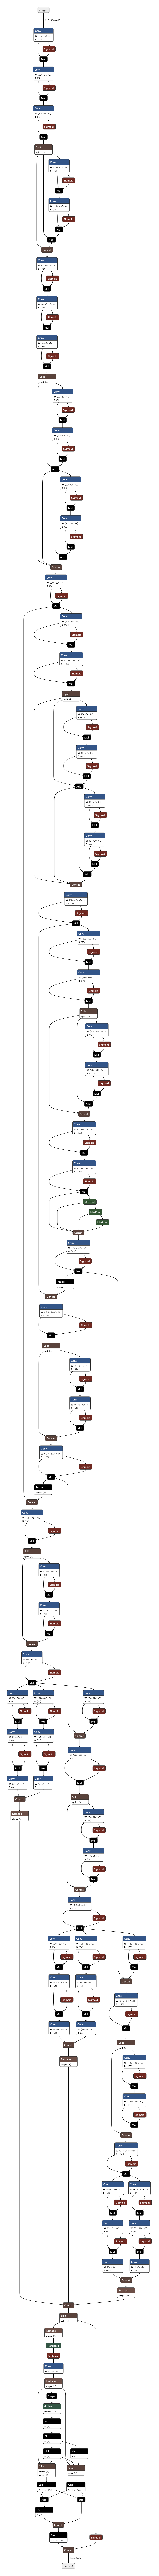

In [48]:
Image(filename='best.onnx.png')

Вы можете скачать полученную `.onnx` модель (или взять из предыдущего экспорта модели) на локальную машину. Далее необходимо открыть сайт [netron.app](https://netron.app/) и нажав "Open Model", выбрать файл с вашей onnx моделью, после чего данный сервис отрисует послойно всю архитектуру сети.

## Архитектура YOLOv8

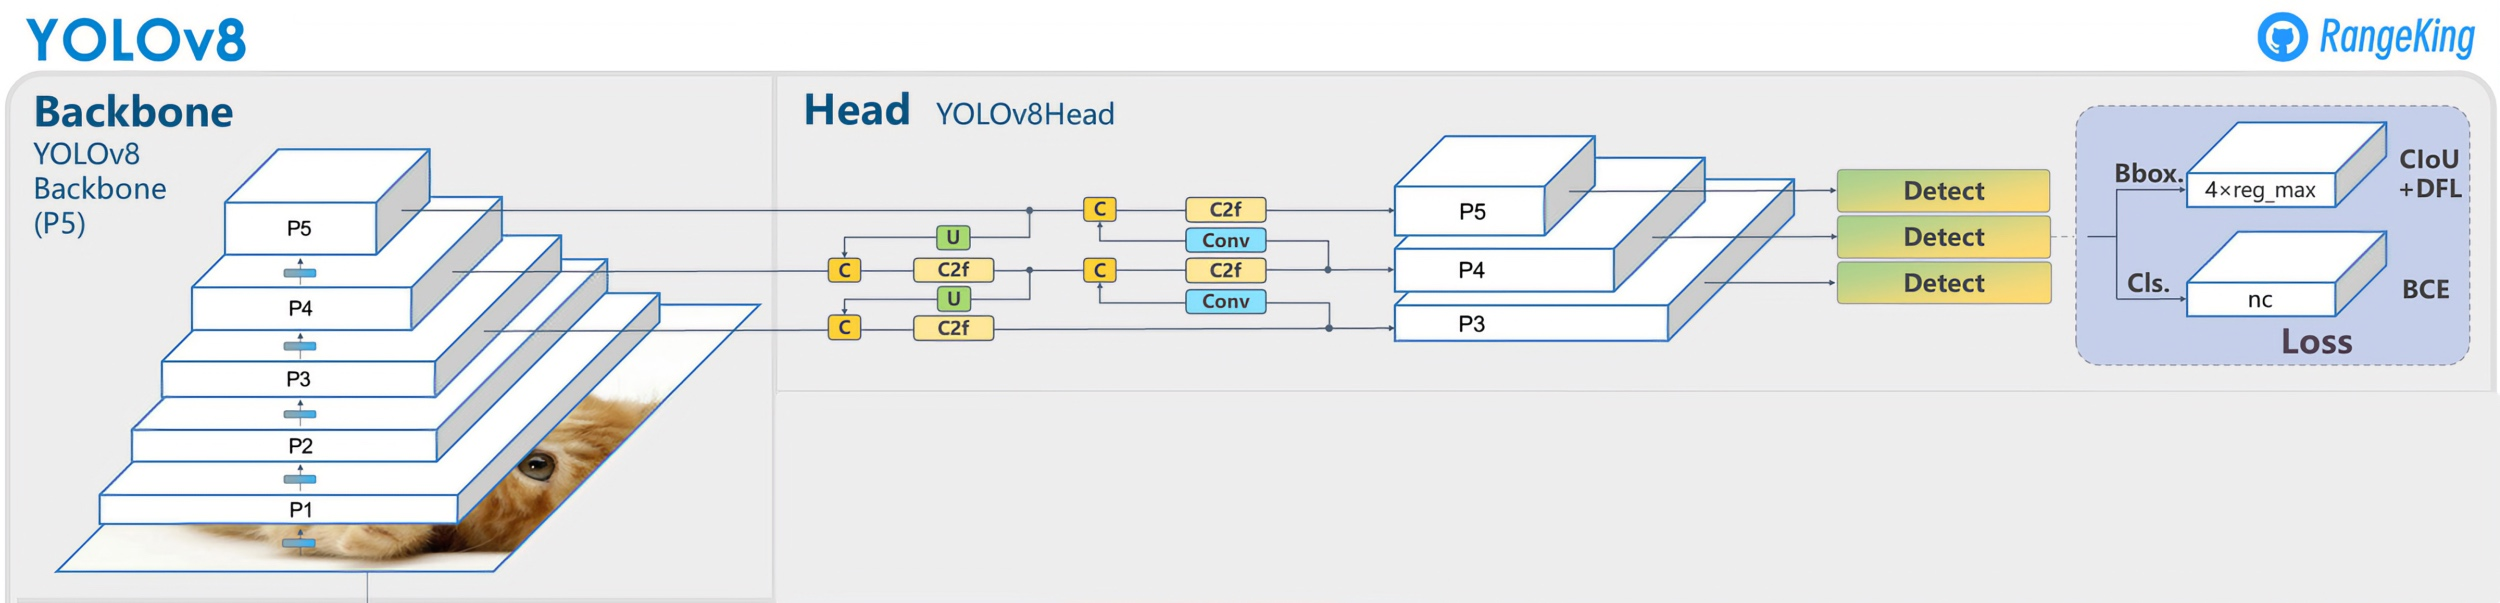
Схема архитектуры

Архитектура YOLOv8 является anchor-free, то есть модель учится напрямую находить координаты объектов на изображении, а не тренируется вычислять коэффициенты для масштрабирования и смещения готовых прямоугольников, чтобы они совпадали с границами объекта.

Пример визуализцаии anchor (якоря) у архитектуры YOLOv5:

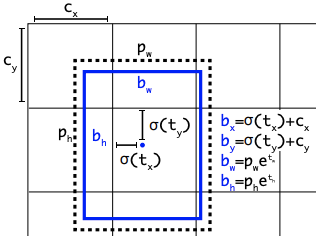

## Запуск ONNX модели
Для сравнения производительности фреймворков запустим модель YOLOv8 с помощью фреймворка PyTorch и библиотеки ONNXRuntime для запуска ONNX моделей.

In [21]:
torch_model = YOLO('yolov8n.pt', task='detect')
onnx_model = YOLO('yolov8n.onnx', task='detect')

# Делаем "пустые" запуски, чтобы модели полностью загрузились в память
_ = torch_model([image])
_ = onnx_model([image])


0: 640x640 1 cup, 2 chairs, 2 couchs, 3 potted plants, 38.9ms
Speed: 7.0ms preprocess, 38.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Loading yolov8n.onnx for ONNX Runtime inference...

0: 640x640 1 cup, 2 chairs, 2 couchs, 3 potted plants, 53.9ms
Speed: 5.0ms preprocess, 53.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


In [22]:
%%time
# Замеряем скорость
_ = torch_model([image])


0: 640x640 1 cup, 2 chairs, 2 couchs, 3 potted plants, 36.9ms
Speed: 10.0ms preprocess, 36.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


CPU times: total: 500 ms
Wall time: 55.9 ms


In [23]:
%%time
_ = onnx_model([image])


0: 640x640 1 cup, 2 chairs, 2 couchs, 3 potted plants, 53.9ms
Speed: 4.0ms preprocess, 53.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


CPU times: total: 625 ms
Wall time: 63.8 ms


In [24]:
#!pip install onnxruntime

## Постобработка результатов модели: Non-maximum suppression
Кроме конвертации в CoreML шаг постобработки не переносится.
Для этого предлагается ознакомиться с его реализацией более детально.
Для начала запустите все ячейки ниже на изображении со случайными пикселями.

## Задание 3
Замените случайно сгенерированное изображение x на реальное обработанное изображение (примеры обработки можете найти в предыдущей лабораторной работе).
После замены запустите все ячейки ниже ещё раз.

In [68]:
import numpy as np
import onnxruntime as ort

image = cv2.imread('test3.jpg', cv2.IMREAD_COLOR)  # Открытие цветного изображения (примечание: открывается в BGR)

#ort_model = ort.InferenceSession('yolov8n.onnx', providers=['CPUExecutionProvider'])
ort_model = ort.InferenceSession('runs/detect/train5/weights/best.onnx', providers=['CPUExecutionProvider'])

model_input_name = ort_model.get_inputs()[0].name
model_output_name = ort_model.get_outputs()[0].name

print(' Input name: {}\n Output name: {}'.format(model_input_name, model_output_name))

#x = np.random.rand(1, 3, 640, 640).astype(np.float32)
x = cv2.resize(image, (480, 480)).astype(np.float32).transpose(2, 0, 1)[None] / 255.0

out = ort_model.run(
    [model_output_name],
    {model_input_name: x}
)

print(out[0].shape)

 Input name: images
 Output name: output0
(1, 6, 4725)


Выход модели YOLO состоит из координат детекций и распределений вероятностей по всем классам, а также значении степени уверенности сети. И 2-я размерность состоит из:
4 (xywh) + 80 (количество классов + фон)

In [74]:
import torch
import torchvision

def xywh2xyxy(x):
  y = np.copy(x)
  y[..., 0] = x[..., 0] - x[..., 2] / 2  # top left x
  y[..., 1] = x[..., 1] - x[..., 3] / 2  # top left y
  y[..., 2] = x[..., 0] + x[..., 2] / 2  # bottom right x
  y[..., 3] = x[..., 1] + x[..., 3] / 2  # bottom right y
  return y

kx = image.shape[1] / 480
ky = image.shape[0] / 480

elem_out = out[0].transpose(0, 2, 1).squeeze()
print(elem_out.shape)

boxes = elem_out[:, :4] * np.array([[kx, ky, kx, ky]])
boxes = xywh2xyxy(boxes)
probs_max_value = elem_out[:, 4:].max(axis=1)
probs_max_index = elem_out[:, 4:].argmax(axis=1)

threshold = 0.1

filter_mask = probs_max_value > threshold

f_boxes = boxes[filter_mask].astype(np.int32)
f_probs_max_value = probs_max_value[filter_mask]
f_probs_max_index = probs_max_index[filter_mask]

keeps_elements = torchvision.ops.nms(
    torch.from_numpy(f_boxes.astype(np.float32)),
    torch.from_numpy(f_probs_max_value),
    0.5
  )

f_boxes = f_boxes[keeps_elements]
f_probs_max_value = f_probs_max_value[keeps_elements]

print(f_boxes.shape)

(4725, 6)
(14, 4)


In [76]:
# Отрисовка результатов

image = cv2.imread('test3.jpg', cv2.IMREAD_COLOR)  # Открытие цветного изображения (примечание: открывается в BGR)

detection_visualization = image.copy()

for detecion_id in range(len(f_boxes)):
  target_object_box = f_boxes[detecion_id]  # XcYcWH format
  target_object_prob = float(f_probs_max_value[detecion_id])

  detection_visualization = cv2.rectangle(
      detection_visualization,
      tuple(target_object_box[:2]),
      tuple(target_object_box[2:]),
      colors[detecion_id % len(colors)],
      5
  )

detection_visualization = cv2.resize(detection_visualization, None, fx=1/2, fy=1/2)

#cv2_imshow(detection_visualization)
cv2.namedWindow('custom window', cv2.WINDOW_KEEPRATIO)
cv2.imshow('custom window', detection_visualization)
cv2.resizeWindow('custom window', 800, 600)
cv2.imwrite('masks2.jpg', detection_visualization)

cv2.waitKey(0)
cv2.destroyAllWindows()

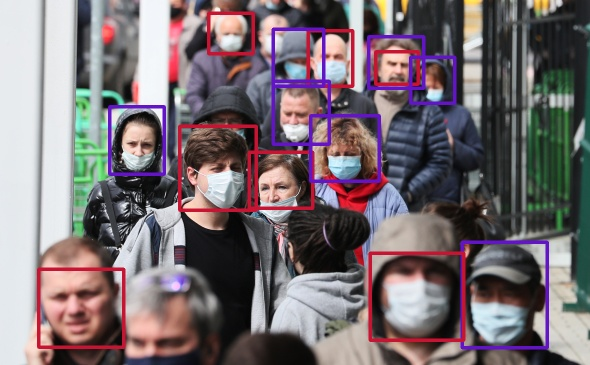

In [77]:
Image(filename='masks2.jpg', width=1000)